<a href="https://colab.research.google.com/github/VitorPaes/hackathon_stn/blob/master/Hackathon_std.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bases


## Planilha com estatísticas básicas de turismo


In [ ]:
url = 'http://dadosefatos.turismo.gov.br/images/demanda/Estatisticas_Basicas_2017_2018.xlsx'

import pandas as pd

DF_list = pd.read_excel(url, None)

df = DF_list['5.2 Oferta hoteleira'].iloc[6:39, 0:10]
df.columns = ["Local","MeioHospedagem_2016","UnidHab_2016","Leitos_2016",
              "MeioHospedagem_2017","UnidHab_2017","Leitos_2017",
              "MeioHospedagem_2018","UnidHab_2018","Leitos_2018"]

for col in list(df.columns):
  try:
    df[col] = df[col].str.strip()
  except:
    pass

df["GeoClass"] = "Estado"
df["GeoClass"].iloc[0] = "País"
df["GeoClass"].loc[df["Local"].isin(["Norte", "Nordeste", "Sudeste",
                                     "Sul", "Centro-Oeste"])] = "Região"


## Selo turismo responsável 
O selo Turismo responsável é uma certificação concedida pelo Governo Federal aos empreendimentos que seguem os protocolos estabelecidos para prevenção da COVID-19.

In [ ]:
url = 'http://www.turismo.gov.br/seloresponsavel/dados/TurismoResponsavelDadosAbertos.csv'  # Turismo responsavel pos-covid
df = pd.read_csv(url, header=5, sep=";")
df["UF"].value_counts()


São Paulo              2836
Rio de Janeiro         1802
Minas Gerais           1055
Bahia                   867
Rio Grande do Sul       652
Santa Catarina          580
Paraná                  570
Rio Grande do Norte     553
Pernambuco              504
Ceará                   451
Alagoas                 445
Maranhão                294
Espírito Santo          224
Goiás                   216
Pará                    159
Paraíba                 140
Mato Grosso do Sul      138
Distrito Federal        137
Amazonas                128
Mato Grosso             116
Sergipe                 108
Piauí                    92
Tocantins                47
Rondônia                 29
Roraima                  15
Amapá                     8
Acre                      4
Name: UF, dtype: int64

In [ ]:
df["Atividade"].value_counts()

Agência de Turismo                                                  4398
Meio de Hospedagem                                                  3635
Transportadora Turística                                            1468
Restaurante, Cafeteria, Bar e Similares                              843
Prestador Especializado em Segmentos Turísticos                      591
Organizadora de Eventos                                              450
Guia de Turismo                                                      271
Prestador de Infraestrutura de Apoio para Eventos                    142
Locadora de Veículos para Turistas                                   135
Parque Aquático e Empreendimento de Lazer                             67
Acampamento Turístico                                                 45
Parque Temático                                                       44
Empreendimento de Apoio ao Turismo Náutico ou à Pesca Desportiva      31
Centro de Convenções                               

In [ ]:
df.groupby(by=["UF", "Atividade"]).count().iloc[:,0]

UF         Atividade                                              
Acre       Agência de Turismo                                           2
           Restaurante, Cafeteria, Bar e Similares                      2
Alagoas    Acampamento Turístico                                        1
           Agência de Turismo                                         108
           Casa de Espetáculos e Equipamento de Animação Turística      1
                                                                     ... 
Tocantins  Organizadora de Eventos                                      1
           Prestador Especializado em Segmentos Turísticos              3
           Prestador de Infraestrutura de Apoio para Eventos            1
           Restaurante, Cafeteria, Bar e Similares                      2
           Transportadora Turística                                     2
Name: Município, Length: 295, dtype: int64

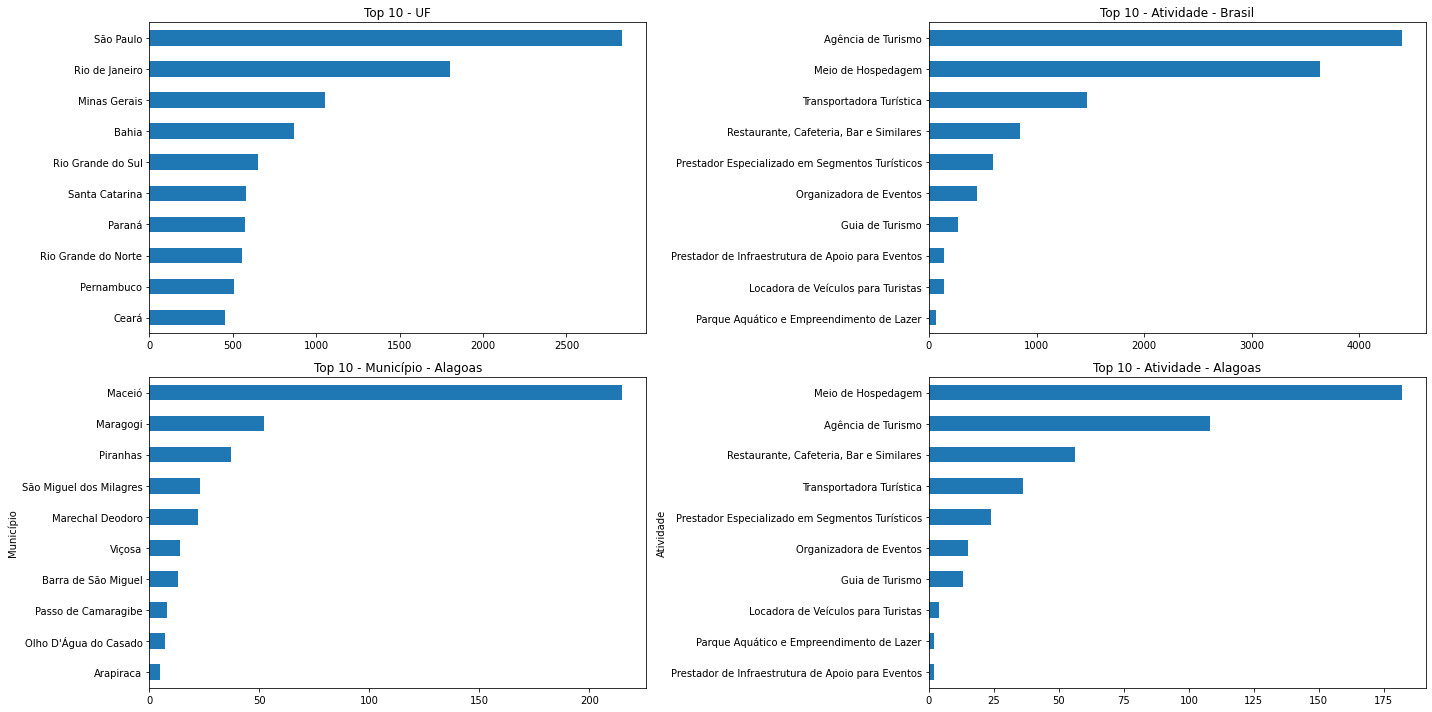

In [ ]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 2, figsize=(20,10))
col = "UF"
df[col].value_counts().nlargest(10).plot.barh(x=col,
                                          legend=False,
                                          ax=axs[0,0],
                                          title='Top 10 - '+col)


col = "Atividade"
df[col].value_counts().nlargest(10).plot.barh(x=col,
                                          legend=False,
                                          ax=axs[0,1],
                                          title='Top 10 - '+col+" - Brasil")

df.groupby(by=["UF", col]).count().iloc[:,0].loc['Alagoas'].nlargest(10).plot.barh(x=col,
                                          legend=False,
                                          ax=axs[1,1],
                                          title='Top 10 - '+col+" - Alagoas")

col = "Município"
df.groupby(by=["UF", col]).count().iloc[:,0].loc['Alagoas'].nlargest(10).plot.barh(x=col,
                                          legend=False,
                                          ax=axs[1,0],
                                          title='Top 10 - '+col+" - Alagoas")


axs[0,0].invert_yaxis()
axs[0,1].invert_yaxis()
axs[1,0].invert_yaxis()
axs[1,1].invert_yaxis()

fig.tight_layout()

In [ ]:
# Dashboards
!pip install plotly==4.9.0

# Static figures to show on GitHub
# !pip install kaleido==0.0.1
# !pip install psutil==5.7.2

In [ ]:
import plotly.express as px
fig = px.treemap(df, path=['UF'], 
                 color_continuous_scale='RdBu',
                 title='Empresas com Selo Turismo Responsável por UF')
fig.show()
# fig.show('png', scale=1.25)  # static

In [ ]:
fig = px.treemap(df, path=['Atividade'], 
                 color_continuous_scale='RdBu',
                 title='Empresas com Selo Turismo Responsável por Atividade')
fig.show()

## Planilha de turismo do Alagoas

In [219]:
url = 'https://raw.githubusercontent.com/VitorPaes/hackathon_stn/master/dataset/convertcsv3.csv'
df = pd.read_csv(url, sep=";", encoding='latin')

for col in ['Nome', 'Município', "Segmento"]:
  df[col] = df[col].str.strip()

col = "Segmento"
df[col] = df[col].str.replace("Sol e Praia","Praia")


col = "Município"
df[col] = df[col].str.replace("-AL","")

col = "Distância da Capital (km)" 
df[col] = df[col].str.replace(",",".").astype('float')

col = "Tempo de condução estimado" 
df[col] = df[col].str.replace(".","")
df[col] = df[col].str.replace("minutos","min")
df[col] = df[col].str.replace(" ","")
df[col] = df[col].str.replace("he",":")

df[col] = df[col].str.replace(r"^([0-9]+)min","00:\\1")
df[col] = df[col].str.replace(r"([0-9]+)h$","\\1:00")
df[col] = df[col].str.replace("min","")
df[col] = df[col].str.replace("^([0-9]):","0\\1:")
df[col] = df[col].str.replace(":([0-9])$",":0\\1")

col = "Latitude" 
df[col] = df[col].astype('str').str.replace(".","")
df[col] = df[col].str.replace("^-9","-9.")
df[col] = df[col].str.replace("^-10","-10.").astype('float')

col = "Longitude"
df[col] = df[col].astype('str').str.replace(".","")
df[col] = df[col].str.replace("^-3","-3.").astype('float')

col = "Segmento"
df[col].value_counts()

Praia                        56
Histórico/Cultural           17
Ecoturismo/Aventura           6
Ecoturismo/Aventura/Praia     1
Name: Segmento, dtype: int64

## Tableau brasil.io

In [84]:
%%html
<div class='tableauPlaceholder' id='viz1596311061648' style='position: relative'><noscript>
  <a href='#'>
    <img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Co&#47;Covid-19Alagoas&#47;MonitorCovid-19-Alagoas&#47;1_rss.png' style='border: none' />
    </a></noscript>
  <object class='tableauViz'  style='display:none;'>
    <param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' />
  <param name='embed_code_version' value='3' />
  <param name='path' value='views&#47;Covid-19Alagoas&#47;MonitorCovid-19-Alagoas?:language=pt&amp;:embed=y&amp;:display_count=y' />
  <param name='toolbar' value='yes' />
  <param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Co&#47;Covid-19Alagoas&#47;MonitorCovid-19-Alagoas&#47;1.png' />
  <param name='animate_transition' value='yes' />
  <param name='display_static_image' value='yes' />
  <param name='display_spinner' value='yes' />
  <param name='display_overlay' value='yes' />
  <param name='display_count' value='yes' />
  <param name='language' value='pt' />
  </object></div>
  <script type='text/javascript'>
  var divElement = document.getElementById('viz1596311061648');
  var vizElement = divElement.getElementsByTagName('object')[0];
  if ( divElement.offsetWidth > 800 ) { vizElement.style.width='100%';
  vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} 
  else if ( divElement.offsetWidth > 500 ) 
  { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';}
   else { vizElement.style.width='100%';vizElement.style.height='1227px';}
  var scriptElement = document.createElement('script');
  scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';
  vizElement.parentNode.insertBefore(scriptElement, vizElement);
  </script>

## Caged
Dados desemprego

In [117]:
url = 'https://github.com/VitorPaes/hackathon_stn/blob/master/dataset/2006_dadosCaged.xlsx?raw=true'
DF_list = pd.read_excel(url, None)


In [147]:
df = DF_list['Tabela 4'].iloc[4:33, 1:31]
df.columns = df.iloc[0]
df.drop(df.index[0],inplace=True)
df.index = df.iloc[:,0]
df.columns = df.columns.fillna('to_drop')
df.drop('to_drop', axis = 1, inplace = True)
df.loc["Alojamento e alimentação"]

4
Rondônia                 -222
Acre                      -48
Amazonas                 -106
Roraima                   -49
Pará                     -142
Amapá                     -29
Tocantins                 -59
Maranhão                 -159
Piauí                    -288
Ceará                    -590
Rio Grande do Norte      -408
Paraíba                  -159
Pernambuco              -1001
Alagoas                  -475
Sergipe                  -247
Bahia                   -1652
Minas Gerais            -3348
Espírito Santo           -705
Rio de Janeiro          -6726
São Paulo              -10412
Paraná                  -2102
Santa Catarina          -1577
Rio Grande do Sul       -1778
Mato Grosso do Sul       -284
Mato Grosso              -363
Goiás                   -1342
Distrito Federal        -1068
Não identificado           -1
Total                  -35340
Name: Alojamento e alimentação, dtype: object

Foram extintos 280.017 empregos no setor de Alojamento e alimentação no Brasil apenas em 2020.

Saldo acumulado 2020:  -280017


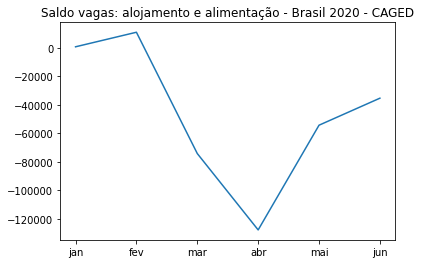

In [192]:
import numpy as np
df = DF_list['Tabela 6'].iloc[4:33, 1:131]
df.columns = df.iloc[0]
df.drop(df.index[0],inplace=True)
df.index = df.iloc[:,0]
df.columns = df.columns.fillna('to_drop')
df.drop('to_drop', axis = 1, inplace = True)

df_red = df.loc[["Alojamento e alimentação"]].drop(columns=["Admissões", "Estoque", "Desligamentos", "Variação Relativa (%)"])
df_red.columns=["jan","fev","mar","abr","mai","jun","jul","ago","set","out","nov","dez",2020]
df_red.iloc[0,6:12]=np.nan
df_red = df_red.T
df_red
plt.plot(df_red["Alojamento e alimentação"].iloc[0:6])
plt.title("Saldo vagas: alojamento e alimentação - Brasil 2020 - CAGED");
print("Saldo acumulado 2020: ", int(df_red.min()))

# Sistema de recomendação

Dados teste

In [243]:
from collections import Counter
from collections import defaultdict



"""
Informações de usuários

Representação: id, nome


"""

usuarios = [
    {"id": 0, "name": "João"},
    {"id": 1, "name": "Pedro"},
    {"id": 2, "name": "Arthur"},
    {"id": 3, "name": "Clara"},
    {"id": 4, "name": "Roberto"},
    {"id": 5, "name": "Júlia"},
    {"id": 6, "name": "Amanda"},
    {"id": 7, "name": "André"},
    {"id": 8, "name": "Eduardo"},
    {"id": 9, "name": "Rafael"},
    
]


"""
Rede de interesse

Representação: id, turismo_tipos

"""

turismo_tipos = [
    (0, "Praia"), (0, "Histórico"),
    (1, "Praia"),
    (2, "Praia"), (2, "Ecoturismo"),
    (3, "Praia"),
    (4, "Praia"), (4, "Aventura"),
    (5, "Praia"), (5, "Negócios"),
    (6, "Praia"), (6, "Ecoturismo"), (6, "Aventura"),
    (7, "Praia"), (7, "Eventos"),
    (8, "Praia"),
    (9, "Histórico")
]

hospedagem_tipos = [
    (0, "Hotel"),
    (1, "Airbnb"), (1, "Pousada"),
    (2, "Casa_Parente"),
    (3, "Pousada"),
    (4, "Casa_Amigo"),
    (5, "Hotel"), (5, "Pousada"),
    (6, "NA"),
    (7, "Casa_Amigo"),
    (8, "Pousada"),
    (9, "Airbnb")
]


alimentacao_tipos = [
    (0, "Pizza"),
    (1, "Churrasco"), (1, "Lanche"),
    (2, "Padaria"),
    (3, "Japonesa"),
    (4, "Frutos_do_mar"),
    (5, "Pizza"),
    (6, "Frutos_do_mar"),
    (7, "NA"),
    (8, "Lanche"), (8, "Pizza"),
    (9, "Churrasco")                     
]




## TODO DICIONARIO COM TERMOS SIMILARES
# ex: Ecoturismo: natureza




Funções auxiliares

In [248]:
def interest_freq(interest_types, interest_name):
  interest_freq = Counter(word for user_id, interest in interest_types
                           for word in interest.lower().split())
  
  print("\nTipos de " + interest_name)
  
  for word, count in interest_freq.most_common():
    if count > 1:
        print(word, count)

  return interest_freq


def turismo_preferencia(target):
    return [id_usuario for id_usuario, turismo in turismo_tipos
            if turismo == target]


def most_popular_new_interests(user_interests, max_results=5):
    recommendations = [
        (interest, frequency)
        for interest, frequency in popular_interests.items()

        if interest not in user_interests
                      ]
    return sorted(recommendations[:max_results], key=lambda x: -x[1])


def cosine_similarity(v, w):
  """
      Compara dois usuários    
  """
  return np.dot(v, w) / np.sqrt(np.dot(v, v) * np.dot(w, w))


def make_user_vector(user_id):
    """
      Criar vetor para um determinado usuário (usuário x interesse)

      1 - Se o usuário tem
      0 - Contrário

    """
    return [1 if interest in interest_by_user_id[user_id]
            else 0 for interest in unique_interest]


def most_similar_users_to(user_id):
    pairs = [(other_user_id, similarity)
            for other_user_id, similarity in enumerate(users_sim_matrix[user_id])
             if user_id != other_user_id and similarity > 0
            ]
    return sorted(pairs, key=lambda x: -x[1])


def user_based_recommendations(user_id, include_current_interests=False):
    """
        Gerar recomendação baseado nos usuários mais similares

    """
    predictions = defaultdict(float)
    for other_user_id, similarity in most_similar_users_to(user_id):
      for interest in interest_by_user_id[other_user_id]:
        # Para cada interesse soma-se a similaridade dos usuários mais proxímos
        predictions[interest] += similarity
        
    # converte as recomendações em uma lista ordenada
    predictions = sorted(predictions.items(), key=lambda x: -x[1])
        
    # caso deseje incluir interesses existentes include_current_interests=True
    if include_current_interests:
        return predictions
     
    else:
        return [(prediction, score) 
            for prediction, score in predictions
                if prediction not in interest_by_user_id[user_id]]


def make_interest_vector(interest):
    """
      Criar vetor para um determinado interesse (interesse x usuários)

      1 - Se o interesse tem o usuário
      0 - Contrário

    """
    return [1 if interest in interest_by_user_id[user_id]
            else 0 for user_id in interest_by_user_id.keys()]


def most_similar_interests_to(interest_id):
    # Imprimir interesses mais similares ao Big Data
    # most_similar_interests_to(0)
    
    similarities = interests_sim_matrix[interest_id]
    pairs = [(unique_interest[other_interest_id], similarity) 
            for other_interest_id, similarity in enumerate(similarities)
            if interest_id != other_interest_id and similarity > 0]
    return sorted(pairs, key=lambda x: -x[1])


def item_based_suggestions(user_id, include_current_interests=False):
    predictions = defaultdict(float)
    user_vector = make_user_vector(user_id)
    
    for interest_id, is_interested in enumerate(user_vector):
        if is_interested == 1:
            similar_interests = most_similar_interests_to(interest_id)
                        
            for interest, similarity in similar_interests:
                predictions[interest] += similarity

     # converte as recomendações em uma lista ordenada
    predictions = sorted(predictions.items(), key=lambda x: -x[1])

    # caso deseje incluir interesses existentes include_current_interests=True
    if include_current_interests:
        return predictions

    else:
        return [(prediction, score) 
               for prediction, score in predictions
               if prediction not in interest_by_user_id[user_id]]

Respostas mais frequentes.

In [ ]:
turismo_freq = interest_freq(turismo_tipos, 'turismo')

hospedagem_freq = interest_freq(hospedagem_tipos, 'hospedagem')

alimentacao_freq = interest_freq(alimentacao_tipos, 'alimentacao')


Tipos de turismo
praia 9
histórico 2
ecoturismo 2
aventura 2

Tipos de hospedagem
pousada 4
hotel 2
airbnb 2
casa_amigo 2

Tipos de alimentacao
pizza 3
churrasco 2
lanche 2
frutos_do_mar 2


In [241]:
id_usuario_por_turismo = defaultdict(list)
turismo_por_id_usuario = defaultdict(list)
turismo_unico = set()

for id_usuario, turismo in turismo_tipos:
    id_usuario_por_turismo[turismo].append(id_usuario)
    turismo_por_id_usuario[id_usuario].append(turismo)
    turismo_unico.add(turismo)

# Ordena em ordem alfabética
turismo_unico = sorted(list(turismo_unico))


In [249]:
popular_turismo = Counter(turismo for user in usuarios 
                            for turismo in turismo_por_id_usuario[user['id']]) 

print("Recomendações para %s:: %s " 
      % (users[0]['name'], most_popular_new_interests(turismo_por_id_usuario[0])))

Recomendações para João:: [('Praia', 9), ('Histórico', 2), ('Ecoturismo', 2), ('Aventura', 2)] 


In [225]:
# Criar matrix de interesses (usuários x interesses)
users_matrix = [make_user_vector(user) for user in interest_by_user_id]

# Criar matrix de similaridade
users_sim_matrix = [[cosine_similarity(interest_vector_v, interest_vector_w) 
                     for interest_vector_w in users_matrix] 
                    for interest_vector_v in users_matrix]


## Usuários mais similares ao João
# most_similar_users_to(0)


## Lista de interesses do João
# print(interest_by_user_id[0])
# Lista de recomendações para o João
user_based_recommendations(0)

[('Ecoturismo', 0.9082482904638631), ('Aventura', 0.9082482904638631)]

In [226]:
# Criar matrix de interesses (usuários x interesses)
interests_matrix = [make_interest_vector(interest) for interest in unique_interest]


# Criar matrix de similaridade
users_sim_matrix = [[cosine_similarity(interest_vector_v, interest_vector_w) 
                     for interest_vector_w in users_matrix] 
                    for interest_vector_v in users_matrix]

# Criar matrix de similaridade
interests_sim_matrix = [[cosine_similarity(user_vector_v, user_vector_w) 
                     for user_vector_w in interests_matrix] 
                    for user_vector_v in interests_matrix]


        

## Lista de interesses do João
# print(interest_by_user_id[0])
# Lista de recomendações para o João
item_based_suggestions(0)

[('Aventura', 0.47140452079103173), ('Ecoturismo', 0.47140452079103173)]